In [ ]:
# 📦 导入库
import os
import socket
import json
import time
import cv2
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime, timedelta
from PIL import Image
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

from torch.utils.data import DataLoader
import multiprocessing
import time
import numpy as np
import torch
from torch.cuda.amp import autocast

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torchvision.models import get_model_weights

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import r2_score

# ⚙️ 全局配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化
if socket.gethostname() == 'hao-2':
    dir = Path('D:/DATA_hao/Kaggle_/csiro-biomass/')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path(dir,"DualStream_multihead"),              
    "data":     Path(dir),   
    }
    
    # # 打印时一行一个地址
    # print("✅ 路径：\n")
    # for key, path in DIRS.items():
    #     print(f"{key:<12} : {path}")
else:
    dir = Path('/kaggle/input/csiro-biomass')
    DIRS = {
    "dir":        dir,                                       
    "train":     Path(dir, "train"),                              
    "test":     Path(dir, "test"),                              
    "model":     Path('/kaggle/input', "dualstream-multihead-model"),              
    "data":     Path("/kaggle/working/"),   
    }

    # # 打印时一行一个地址
    # print("✅ 路径：\n")
    # for key, path in DIRS.items():
    #     print(f"{key:<12} : {path}")

# 小函数
def show_df_info(df, name: str):
    """
    打印单个 DataFrame 的形状与列名信息。
    参数:
        df   : pandas.DataFrame
        name : 显示名称（字符串）
    """
    print(f"📊 {name:<16} shape: {str(df.shape):<16}  列名: {df.columns.tolist()}")

def move_column_first(df, col_name):
    """
    将 DataFrame 中指定列移动到最前面。
    参数:
        df (pd.DataFrame): 原始数据框
        col_name (str): 要移动到最前面的列名
    返回:
        pd.DataFrame: 调整后的新 DataFrame
    """
    if col_name not in df.columns:
        raise ValueError(f"列 '{col_name}' 不存在于 DataFrame 中。")

    cols = [col_name] + [c for c in df.columns if c != col_name]
    return df[cols]

# 🧮 后处理函数（恢复 5 个目标）
def recover_all_targets(df_pred_3):
    df = df_pred_3.copy()
    df["Dry_Clover_g"] = np.maximum(0, df["GDM_g"] - df["Dry_Green_g"])
    df["Dry_Dead_g"] = np.maximum(0, df["Dry_Total_g"] - df["GDM_g"])
    return df[["Dry_Green_g", "Dry_Dead_g", "Dry_Clover_g", "GDM_g", "Dry_Total_g"]]



In [ ]:
# 📘 训练数据读取与预处理
def load_and_prepare_train_df():
    # 1️⃣ 读取原始数据
    df_file_path = Path(DIRS["dir"]) / "train.csv"
    df = pd.read_csv(df_file_path)
    # show_df_info(df, "train.csv")

    # 2️⃣ 提取唯一 ID（例如 "ID1011485656__Dry_Green_g" → "ID1011485656"）
    df["ID"] = df["sample_id"].str.split("__").str[0]

    # 3️⃣ 将 ID 列移动到最前面
    df = move_column_first(df, "ID")
    # show_df_info(df, "df")

    # 4️⃣ 目标值透视（行转列）
    df_targets = (
        df
        .pivot_table(
            index="ID",
            columns="target_name",
            values="target",
            aggfunc="first"
        )
        .reset_index()
    )
    df_targets.columns.name = None  # 去掉多级列名层次
    # show_df_info(df_targets, "df_targets")

    # 5️⃣ 提取元信息（每个 ID 仅保留一行）
    meta_cols = [
        "ID", "image_path", "Sampling_Date", "State",
        "Species", "Pre_GSHH_NDVI", "Height_Ave_cm"
    ]
    df_meta = df[meta_cols].drop_duplicates(subset="ID")
    # show_df_info(df_meta, "df_meta")

    # 6️⃣ 合并元信息与目标数据
    df_train = pd.merge(df_meta, df_targets, on="ID", how="left")
    show_df_info(df_train, "df_train")

    
    return df_train



In [13]:
# 读取训练数据
df_train = load_and_prepare_train_df()

📊 df_train         shape: (357, 12)         列名: ['ID', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


In [ ]:
# 仅在训练集上计算
mean = df_train[['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g']].mean()
std  = df_train[['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g']].std(ddof=0)
stats = {"mean": mean.values.tolist(), "std": std.values.tolist()}
stats

In [ ]:
# GDM_g       = Dry_Green_g + Dry_Clover_g
# Dry_Total_g = Dry_Green_g + Dry_Clover_g + Dry_Dead_g


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 确保已有误差列
df_train['calc_GDM'] = df_train['Dry_Green_g'] + df_train['Dry_Clover_g']
df_train['calc_Total'] = df_train['Dry_Green_g'] + df_train['Dry_Clover_g'] + df_train['Dry_Dead_g']

df_train['diff_GDM'] = df_train['GDM_g'] - df_train['calc_GDM']
df_train['diff_Total'] = df_train['Dry_Total_g'] - df_train['calc_Total']

abs_diff_gdm = df_train['diff_GDM'].abs()
abs_diff_total = df_train['diff_Total'].abs()

# 定义区间边界
bins = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
labels = [f"{bins[i]} - {bins[i+1]}" for i in range(len(bins)-1)]

# 分桶统计
gdm_counts = pd.cut(abs_diff_gdm, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()
total_counts = pd.cut(abs_diff_total, bins=bins, labels=labels, include_lowest=True).value_counts().sort_index()

# ➕ 计算区间外的两端
gdm_below = (abs_diff_gdm < bins[0]).sum()
gdm_above = (abs_diff_gdm > bins[-1]).sum()
total_below = (abs_diff_total < bins[0]).sum()
total_above = (abs_diff_total > bins[-1]).sum()

# ➕ 整合结果表
df_err_dist = pd.DataFrame({
    "Error Range": ["<1e-6"] + labels + [">100"],
    "GDM_count": [gdm_below] + list(gdm_counts.values) + [gdm_above],
    "Total_count": [total_below] + list(total_counts.values) + [total_above]
})

# 计算比例（百分比）
df_err_dist["GDM_pct(%)"] = df_err_dist["GDM_count"] / len(df_train) * 100
df_err_dist["Total_pct(%)"] = df_err_dist["Total_count"] / len(df_train) * 100

print("📊 误差数量级分布（含两端外样本）")
print(df_err_dist)


In [ ]:
x = np.arange(len(df_err_dist))
width = 0.35

plt.figure(figsize=(11,5))
plt.bar(x - width/2, df_err_dist["GDM_count"], width, label='GDM_diff', color='steelblue')
plt.bar(x + width/2, df_err_dist["Total_count"], width, label='Total_diff', color='seagreen')

plt.xticks(x, df_err_dist["Error Range"], rotation=45)
plt.yscale('log')
plt.ylabel("Sample Count (log scale)")
plt.title("Absolute Error Magnitude Distribution (with boundaries)")
plt.legend()
plt.tight_layout()
plt.show()


# 作弊脚本

In [69]:
import numpy as np
import pandas as pd

def analyze_value_distribution(values, col_name):
    """
    统计单列数值分布：
      0~1 每0.1为间隔，
      1~10 每1为间隔，
      >10 合并。
    """
    values = np.asarray(values)
    n_total = len(values)

    # 定义区间
    bins = np.concatenate([
        np.arange(0, 1.1, 0.1),   # 0, 0.1, 0.2, ..., 1.0
        np.arange(2, 11, 1)       # 2,3,...,10
    ])
    labels = [f"[{bins[i]:.1f}, {bins[i+1]:.1f})" for i in range(len(bins)-1)]
    labels.append("[>=10]")

    # 统计每个区间的数量
    bin_edges = np.append(bins, np.inf)
    counts, _ = np.histogram(values, bins=bin_edges)
    percents = counts / n_total * 100

    # 输出结果
    df_stats = pd.DataFrame({
        "区间": labels,
        "样本数": counts,
        "占比(%)": percents.round(2)
    })
    print(f"\n📊 [{col_name}] 数值分布统计")
    print(df_stats.to_string(index=False))
    print(f"总计样本: {n_total}")

    return df_stats


In [15]:
cols = ['ID', 'Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g',  'Dry_Total_g']
df_true = df_train[cols].copy()
df_true.head()

,ID,Dry_Green_g,Dry_Clover_g,Dry_Dead_g,GDM_g,Dry_Total_g
0,ID1011485656,16.2751,0.0000,31.9984,16.2750,48.2735
1,ID1012260530,7.6000,0.0000,0.0000,7.6000,7.6000
2,ID1025234388,0.0000,6.0500,0.0000,6.0500,6.0500
3,ID1028611175,24.2376,0.0000,30.9703,24.2376,55.2079
4,ID1035947949,10.5261,0.4343,23.2239,10.9605,34.1844


In [81]:
df_pred_CMT = pd.read_excel(r"D:\DATA_hao\Kaggle_\csiro-biomass\DualStream_multihead\main_pipline_GPU_CMT\df_pred_final.xlsx")
df_pred_CMT.head()
df_pred_GCD = pd.read_excel(r"D:\DATA_hao\Kaggle_\csiro-biomass\DualStream_multihead\main_pipline_GPU_GCD\df_pred_final.xlsx")
df_pred_GCD.head()
cols = ['ID', 'Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g',  'Dry_Total_g']
df_true = load_and_prepare_train_df()[cols].copy()
df_true.head()


📊 df_train         shape: (357, 12)         列名: ['ID', 'image_path', 'Sampling_Date', 'State', 'Species', 'Pre_GSHH_NDVI', 'Height_Ave_cm', 'Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'Dry_Total_g', 'GDM_g']


,ID,Dry_Green_g,Dry_Clover_g,Dry_Dead_g,GDM_g,Dry_Total_g
0,ID1011485656,16.2751,0.0000,31.9984,16.2750,48.2735
1,ID1012260530,7.6000,0.0000,0.0000,7.6000,7.6000
2,ID1025234388,0.0000,6.0500,0.0000,6.0500,6.0500
3,ID1028611175,24.2376,0.0000,30.9703,24.2376,55.2079
4,ID1035947949,10.5261,0.4343,23.2239,10.9605,34.1844


In [82]:
cols = ['ID', 'Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']

# 只保留关心列并按 ID 排序
df_true      = df_true[cols].sort_values('ID').reset_index(drop=True)
df_pred_CMT  = df_pred_CMT[cols].sort_values('ID').reset_index(drop=True)
df_pred_GCD  = df_pred_GCD[cols].sort_values('ID').reset_index(drop=True)

# 验证是否完全匹配
assert all(df_true['ID'] == df_pred_CMT['ID']) and all(df_true['ID'] == df_pred_GCD['ID']), "❌ ID 不匹配，请检查。"

In [25]:
import numpy as np

def compute_kaggle_r2(df_true, df_pred):
    # 指定目标列顺序（Kaggle 官方定义）
    target_cols = ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']
    weights = np.array([0.1, 0.1, 0.1, 0.2, 0.5], dtype=float)

    # 转换为 numpy 数组 (float)
    y_true = df_true[target_cols].to_numpy(dtype=float)
    y_pred = df_pred[target_cols].to_numpy(dtype=float)

    # 展平
    y_true_flat = np.concatenate([y_true[:, i] for i in range(5)])
    y_pred_flat = np.concatenate([y_pred[:, i] for i in range(5)])
    w_flat = np.concatenate([
        np.full_like(y_true[:, i], weights[i], dtype=float)
        for i in range(5)
    ])

    # 计算全局加权 R²
    y_mean = np.sum(w_flat * y_true_flat) / np.sum(w_flat)
    ss_res = np.sum(w_flat * (y_true_flat - y_pred_flat) ** 2)
    ss_tot = np.sum(w_flat * (y_true_flat - y_mean) ** 2)

    r2_global = 1 - ss_res / ss_tot
    return r2_global


In [26]:
r2_global = compute_kaggle_r2(df_true, df_pred)
print(f"🌍 Kaggle 官方全局加权 R² = {r2_global:.6f}")

🌍 Kaggle 官方全局加权 R² = 0.920925


In [54]:
# 创建副本
df_pred_clip = df_pred.copy()

# 将 Dry_Clover_g < 0.6 的预测值设为 0
# df_pred_clip.loc[df_pred_clip["Dry_Clover_g"] < 0.6, "Dry_Clover_g"] = 0

# （可选）保持物理一致性
df_pred_clip["GDM_g"] = df_pred_clip["GDM_g"]  
df_pred_clip["Dry_Total_g"] = df_pred_clip["Dry_Total_g"]  - 5
r2_global = compute_kaggle_r2(df_true, df_pred_clip)
print(f"🌍 Kaggle 官方全局加权 R² = {r2_global:.6f}")

🌍 Kaggle 官方全局加权 R² = 0.896740



📊 [Dry_Clover_g] 数值分布统计
         区间  样本数  占比(%)
 [0.0, 0.1)  136  38.10
 [0.1, 0.2)    4   1.12
 [0.2, 0.3)    4   1.12
 [0.3, 0.4)    4   1.12
 [0.4, 0.5)    5   1.40
 [0.5, 0.6)    6   1.68
 [0.6, 0.7)    1   0.28
 [0.7, 0.8)    5   1.40
 [0.8, 0.9)    3   0.84
 [0.9, 1.0)    2   0.56
 [1.0, 2.0)   27   7.56
 [2.0, 3.0)   18   5.04
 [3.0, 4.0)   16   4.48
 [4.0, 5.0)   11   3.08
 [5.0, 6.0)   15   4.20
 [6.0, 7.0)    8   2.24
 [7.0, 8.0)    8   2.24
 [8.0, 9.0)    4   1.12
[9.0, 10.0)    3   0.84
     [>=10]   77  21.57
总计样本: 357

📊 [Dry_Dead_g] 数值分布统计
         区间  样本数  占比(%)
 [0.0, 0.1)   40  11.20
 [0.1, 0.2)    0   0.00
 [0.2, 0.3)    0   0.00
 [0.3, 0.4)    1   0.28
 [0.4, 0.5)    1   0.28
 [0.5, 0.6)    0   0.00
 [0.6, 0.7)    0   0.00
 [0.7, 0.8)    0   0.00
 [0.8, 0.9)    0   0.00
 [0.9, 1.0)    0   0.00
 [1.0, 2.0)   18   5.04
 [2.0, 3.0)   23   6.44
 [3.0, 4.0)   26   7.28
 [4.0, 5.0)   18   5.04
 [5.0, 6.0)   17   4.76
 [6.0, 7.0)   17   4.76
 [7.0, 8.0)   18   5.04
 [8.0,

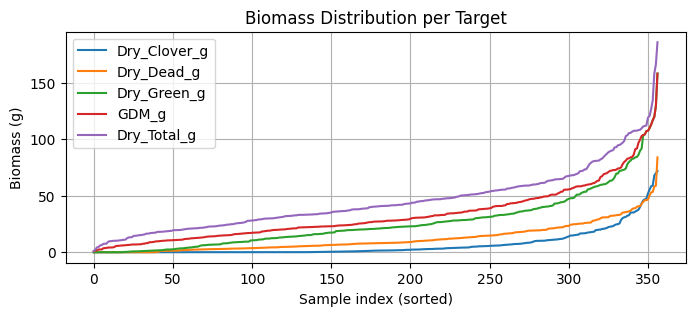

In [74]:
import matplotlib.pyplot as plt

df = df_true
cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g',  'Dry_Total_g']
# cols = ['Dry_Clover_g']
# cols = ['Dry_Dead_g']
# cols = ['Dry_Green_g']

plt.figure(figsize=(8,3))
for col in cols:
    analyze_value_distribution(df[col].values, col)

    plt.plot(sorted(df[col].values), label=col)

plt.xlabel("Sample index (sorted)")
plt.ylabel("Biomass (g)")
# plt.ylim([-0.1,1])
plt.title("Biomass Distribution per Target")
plt.legend()
plt.grid(True)
plt.show()


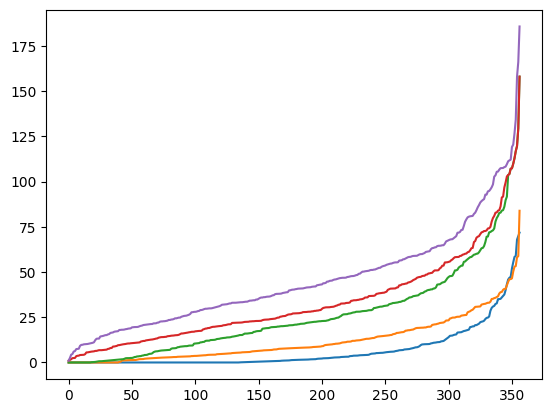

In [75]:

plt.plot(sorted(df["Dry_Clover_g"].values), label="Dry_Clover_g")
plt.plot(sorted(df["Dry_Dead_g"].values), label="Dry_Dead_g")
plt.plot(sorted(df["Dry_Green_g"].values), label="Dry_Green_g")
plt.plot(sorted(df["GDM_g"].values), label="GDM_g")
plt.plot(sorted(df["Dry_Total_g"].values), label="Dry_Total_g")


📊 [Dry_Clover_g] 数值分布统计
         区间  样本数  占比(%)
 [0.0, 0.1)  136  38.10
 [0.1, 0.2)    4   1.12
 [0.2, 0.3)    4   1.12
 [0.3, 0.4)    4   1.12
 [0.4, 0.5)    5   1.40
 [0.5, 0.6)    6   1.68
 [0.6, 0.7)    1   0.28
 [0.7, 0.8)    5   1.40
 [0.8, 0.9)    3   0.84
 [0.9, 1.0)    2   0.56
 [1.0, 2.0)   27   7.56
 [2.0, 3.0)   18   5.04
 [3.0, 4.0)   16   4.48
 [4.0, 5.0)   11   3.08
 [5.0, 6.0)   15   4.20
 [6.0, 7.0)    8   2.24
 [7.0, 8.0)    8   2.24
 [8.0, 9.0)    4   1.12
[9.0, 10.0)    3   0.84
     [>=10]   77  21.57
总计样本: 357


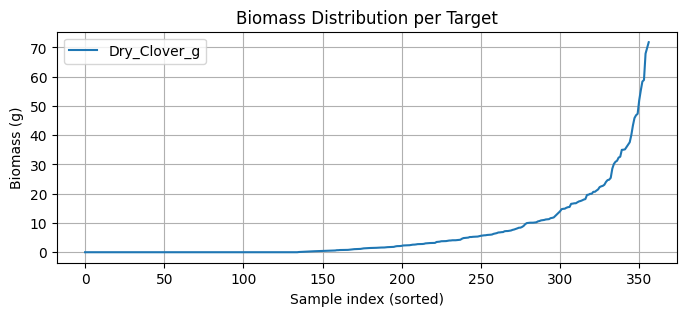

In [76]:
cols = ['Dry_Clover_g', 'Dry_Dead_g', 'Dry_Green_g', 'GDM_g',  'Dry_Total_g']
cols = ['Dry_Clover_g']

df = df_train
plt.figure(figsize=(8,3))
for col in cols:
    analyze_value_distribution(df[col].values, col)

    plt.plot(sorted(df[col].values), label=col)

plt.xlabel("Sample index (sorted)")
plt.ylabel("Biomass (g)")
# plt.ylim([-0.1,1])
plt.title("Biomass Distribution per Target")
plt.legend()
plt.grid(True)
plt.show()


In [60]:
import numpy as np
import pandas as pd

def estimate_noise_levels(df_true, df_pred, min_value=1.0):
    """
    估计每个目标的相对误差标准差（噪声比例），自动跳过真实值过小的样本。
    min_value: 小于该值的真实样本不会参与相对误差计算
    """
    cols = ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']
    noise_stats = {}

    for col in cols:
        y_true = df_true[col].to_numpy(dtype=float)
        y_pred = df_pred[col].to_numpy(dtype=float)

        # 只取真实值大于 min_value 的样本（避免除以0）
        mask = y_true > min_value
        if mask.sum() == 0:
            noise_stats[col] = {"mean_relative_bias": np.nan, "std_relative_noise": np.nan}
            continue

        rel_error = (y_pred[mask] - y_true[mask]) / y_true[mask]
        noise_stats[col] = {
            "mean_relative_bias": np.mean(rel_error),
            "std_relative_noise": np.std(rel_error)
        }

    return pd.DataFrame(noise_stats).T


In [66]:
noise_df = estimate_noise_levels(df_true, df_pred)
print(noise_df)


              mean_relative_bias  std_relative_noise
Dry_Green_g             0.097092            0.712637
Dry_Clover_g            0.072030            0.537768
Dry_Dead_g              0.131795            0.602165
GDM_g                   0.064384            0.279312
Dry_Total_g             0.034106            0.232671


In [62]:
import numpy as np
import pandas as pd

def simulate_model_noise(df_true, noise_level=0.1, scheme='A'):
    """
    模拟预测误差并根据方案 A/B 重构完整五个目标。
    noise_level: 噪声比例 (0.1 = 10%)
    scheme: 'A' or 'B'
    """
    df_pred_sim = df_true.copy()

    if scheme == 'A':
        # 方案A：模型预测 C, GDM, Total
        # 模拟模型预测误差（乘以噪声因子）
        for col in ['Dry_Clover_g', 'GDM_g', 'Dry_Total_g']:
            df_pred_sim[col] = df_true[col] * (1 + np.random.normal(0, noise_level, len(df_true)))

        # 差分推导其他两个
        df_pred_sim['Dry_Green_g'] = df_pred_sim['GDM_g'] - df_pred_sim['Dry_Clover_g']
        df_pred_sim['Dry_Dead_g']  = df_pred_sim['Dry_Total_g'] - df_pred_sim['GDM_g']

    elif scheme == 'B':
        # 方案B：模型预测 G, C, D
        for col in ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g']:
            df_pred_sim[col] = df_true[col] * (1 + np.random.normal(0, noise_level, len(df_true)))

        # 加法推导其他两个
        df_pred_sim['GDM_g']       = df_pred_sim['Dry_Green_g'] + df_pred_sim['Dry_Clover_g']
        df_pred_sim['Dry_Total_g'] = df_pred_sim['GDM_g'] + df_pred_sim['Dry_Dead_g']
    else:
        raise ValueError("scheme must be 'A' or 'B'")

    # clip 防止负值
    df_pred_sim = df_pred_sim.clip(lower=0)
    return df_pred_sim



In [63]:

# ------------------------------------------
# 🧪 多噪声水平测试
# ------------------------------------------
noise_levels = [0.01, 0.05, 0.1, 0.2, 0.3]

# 指定目标列顺序（Kaggle 官方定义）
target_cols = ['Dry_Green_g', 'Dry_Clover_g', 'Dry_Dead_g', 'GDM_g', 'Dry_Total_g']


results = []
for noise in noise_levels:
    pred_A = simulate_model_noise(df_true[target_cols], noise_level=noise, scheme='A')
    pred_B = simulate_model_noise(df_true[target_cols], noise_level=noise, scheme='B')

    r2_A = compute_kaggle_r2(df_true, pred_A)
    r2_B = compute_kaggle_r2(df_true, pred_B)

    results.append((noise, r2_A, r2_B))

# 输出结果
df_result = pd.DataFrame(results, columns=['Noise_Level', 'R2_A', 'R2_B'])
print(df_result)


   Noise_Level      R2_A      R2_B
0         0.01  0.999678  0.999833
1         0.05  0.991955  0.995062
2         0.10  0.969600  0.981417
3         0.20  0.874794  0.910091
4         0.30  0.755690  0.854550
